In [64]:
#Import libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import shap
from sklearn.model_selection import KFold


In [2]:
dataset = pd.read_csv("Data/Dataset_spine.csv")
#Removing the unnecesary last column
del dataset["Unnamed: 13"]


#CSV file describes the attributes as such

#We need to rename the columns so they match
dataset.rename(columns = {
    "Col1" : "pelvic_incidence", 
    "Col2" : "pelvic_tilt",
    "Col3" : "lumbar_lordosis_angle",
    "Col4" : "sacral_slope", 
    "Col5" : "pelvic_radius",
    "Col6" : "degree_spondylolisthesis", 
    "Col7" : "pelvic_slope",
    "Col8" : "direct_tilt",
    "Col9" : "thoracic_slope", 
    "Col10" :"cervical_tilt", 
    "Col11" : "sacrum_angle",
    "Col12" : "scoliosis_slope", 
    "Class_att" : "class"}, inplace=True)

dataset.head()


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


In [3]:
#Check for NULL count and data types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   pelvic_slope              310 non-null    float64
 7   direct_tilt               310 non-null    float64
 8   thoracic_slope            310 non-null    float64
 9   cervical_tilt             310 non-null    float64
 10  sacrum_angle              310 non-null    float64
 11  scoliosis_slope           310 non-null    float64
 12  class                     310 non-null    object 
dtypes: float64(12), object(1)
memory usage: 31.6+ KB


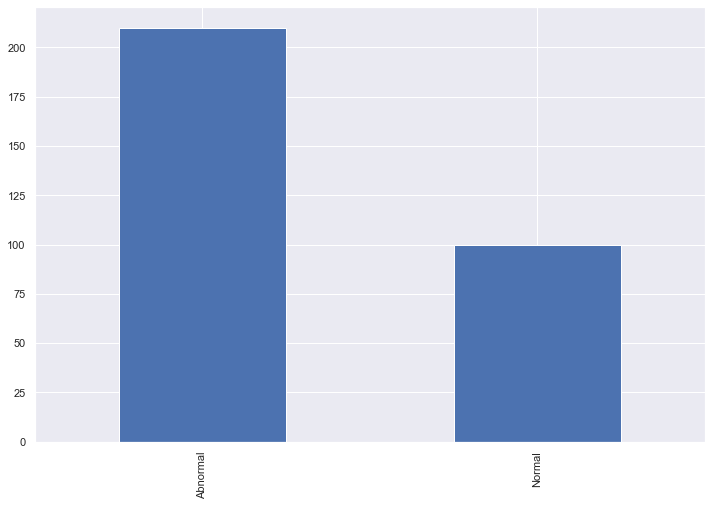

In [4]:
#Check for Balance
dataset["class"].value_counts().sort_index().plot.bar()

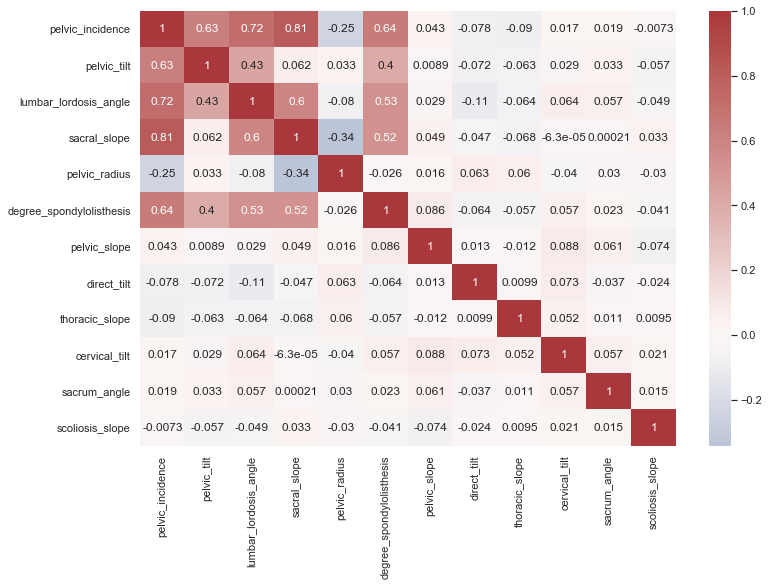

In [5]:
#Check for correlation
sns.heatmap(dataset.corr(), annot = True, center=0, cmap = 'vlag')
#According to https://josr-online.biomedcentral.com/articles/10.1186/s13018-018-0762-9, 
#pelvic incidence = pelvic tilt + sacral slope. Which means we could potentially remove this feature.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Text xticklabel objects>)

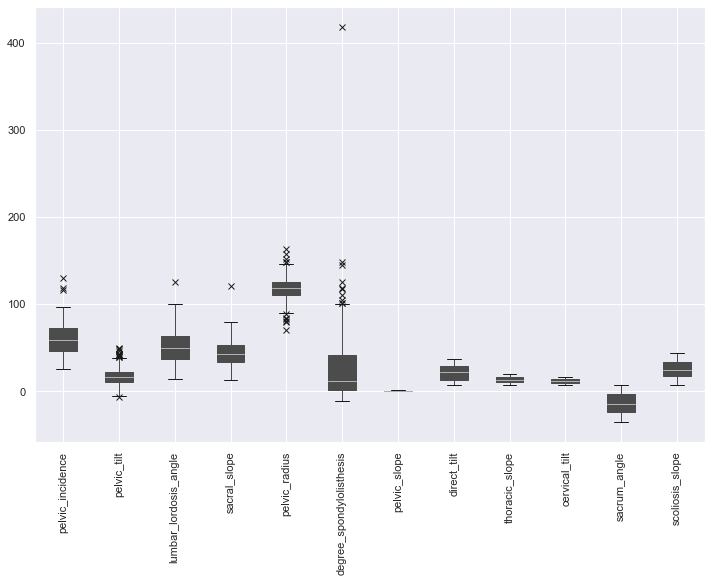

In [6]:
#Box plot for outliers
dataset.boxplot(patch_artist = True, sym = 'kx') 
plt.xticks(rotation=90)

In [7]:
#Removing one outlier in degree_spondylolisthesis
ind_outlier = dataset['degree_spondylolisthesis'].idxmax(axis=0)
med = dataset['degree_spondylolisthesis'].median()
dataset['degree_spondylolisthesis'][ind_outlier]= med


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Text xticklabel objects>)

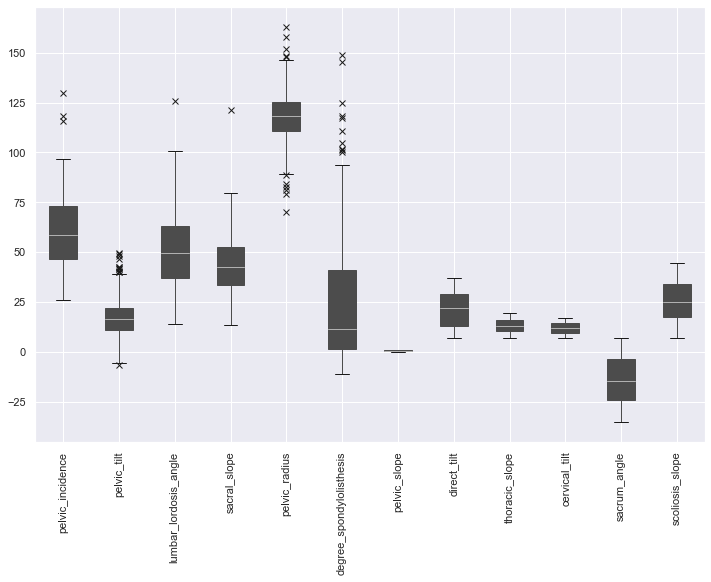

In [8]:
#Box plot for outliers
dataset.boxplot(patch_artist = True, sym = 'kx') 
plt.xticks(rotation=90)

In [9]:
X = dataset.iloc[:, :-1]
Y = pd.get_dummies(dataset, columns = ['class'])
Y = Y.iloc[:,-2:]

In [37]:
def create_MLP():
    model = Sequential()
    model.add(Dense(8, input_shape = (12,), activation = 'relu', name ='FC1'))
    model.add(Dense(4, name = 'FC2'))
    model.add(Dense(2, activation = "softmax", name = 'Output'))
    
    optimizer = Adam(learning_rate = 0.001)
    model.compile(optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    return model

In [39]:
#Getting the hold out set(test set)
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

my_callbacks = [model_checkpoint_callback]

In [72]:
#Defining K-folds Cross Validator
kfold = KFold(n_splits = 10, shuffle = True)
n_fold = 1
reports = []
c_matrices = []
for train, test in kfold.split(X):
    
    x_train = X.iloc[train]
    y_train = Y.iloc[train]
    x_test = X.iloc[test]
    y_test = Y.iloc[test]
    
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)


    MLP_model = create_MLP()
    
    print('\nTraining for fold ', n_fold)
    history_MLP = MLP_model.fit(x_train_scaled, 
                                y_train,
                                verbose = 0, 
                                batch_size = 4, 
                                epochs = 200, 
                                validation_split = 0.1, 
                                callbacks = my_callbacks)
    
    y_pred = MLP_model.predict(x_test_scaled)
    y_tens = tf.convert_to_tensor(y_test)
    target_names = ['Abnormal', 'Normal']
    report = classification_report(np.argmax(y_tens,axis=1), np.argmax(y_pred,axis=1), target_names= target_names, output_dict=True)
    c_matrix = confusion_matrix(np.argmax(y_tens,axis=1), np.argmax(y_pred,axis=1))
    
    reports.append(report)
    c_matrices.append(c_matrix)
    n_fold = n_fold + 1



Training for fold  1

Training for fold  2

Training for fold  3

Training for fold  4

Training for fold  5

Training for fold  6

Training for fold  7

Training for fold  8

Training for fold  9

Training for fold  10


In [93]:
MLP_model.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FC1 (Dense)                  (None, 8)                 104       
_________________________________________________________________
FC2 (Dense)                  (None, 4)                 36        
_________________________________________________________________
Output (Dense)               (None, 2)                 10        
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________


Precision
DescribeResult(nobs=10, minmax=(0.7272727272727273, 0.9565217391304348), mean=0.8560455997540396, variance=0.005924958429507177, skewness=-0.46853777138145436, kurtosis=-0.7023881863329562)
DescribeResult(nobs=10, minmax=(0.5555555555555556, 1.0), mean=0.7807503607503608, variance=0.024026582564461347, skewness=0.2334778004378178, kurtosis=-1.2392766654745362)

Recall
DescribeResult(nobs=10, minmax=(0.7894736842105263, 1.0), mean=0.9072196565194277, variance=0.004889578320235011, skewness=-0.2435447318765621, kurtosis=-0.8845511268820014)
DescribeResult(nobs=10, minmax=(0.5384615384615384, 0.875), mean=0.687991452991453, variance=0.015929475004261333, skewness=0.3564885889116151, kurtosis=-1.5044859167026978)

F1 score
DescribeResult(nobs=10, minmax=(0.8181818181818182, 0.9387755102040816), mean=0.8769392677976086, variance=0.0017942898734037349, skewness=-0.13726620378775334, kurtosis=-1.4428460287776401)
DescribeResult(nobs=10, minmax=(0.5555555555555556, 0.8333333333333333

([<matplotlib.axis.XTick at 0x1e2c1b36608>,
 <a list of 6 Text xticklabel objects>)

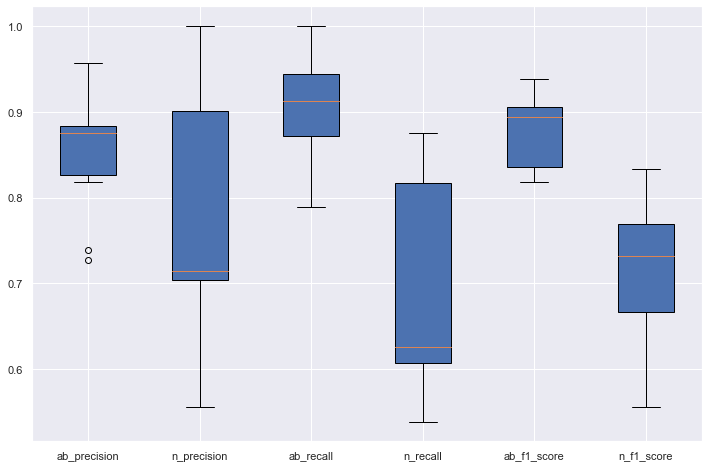

In [94]:
ab_precision = []
n_precision = []
ab_recall = []
n_recall = []
ab_f1_score = []
n_f1_score = []
ab_support = []
n_support = []

for i in range(10):
    ab_precision.append(reports[i]["Abnormal"]["precision"])
    n_precision.append(reports[i]["Normal"]["precision"])
    ab_recall.append(reports[i]["Abnormal"]["recall"])
    n_recall.append(reports[i]["Normal"]["recall"])
    ab_f1_score.append(reports[i]["Abnormal"]["f1-score"])
    n_f1_score.append(reports[i]["Normal"]["f1-score"])
    ab_support.append(reports[i]["Abnormal"]["support"])
    n_support.append(reports[i]["Normal"]["support"])

print("Precision")
print(stats.describe(ab_precision))
print(stats.describe(n_precision))

print("\nRecall")
print(stats.describe(ab_recall))
print(stats.describe(n_recall))

print('\nF1 score')
print(stats.describe(ab_f1_score))
print(stats.describe(n_f1_score))

print('\nSupport')
print(stats.describe(ab_support))
print(stats.describe(n_support))



data = [ab_precision, n_precision, ab_recall, n_recall, ab_f1_score, n_f1_score]
plt.boxplot(data, patch_artist=True)
plt.xticks([1,2,3,4,5,6],['ab_precision', 'n_precision', 'ab_recall', 'n_recall', 'ab_f1_score', 'n_f1_score'])

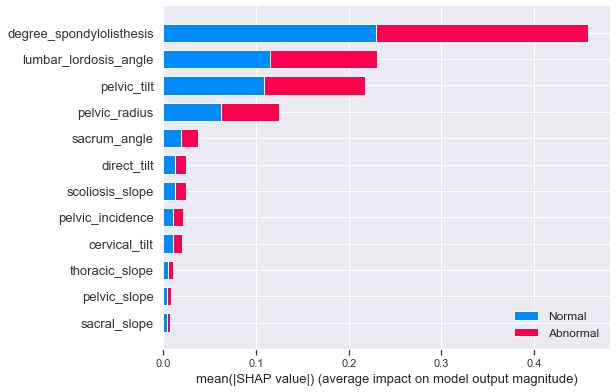

In [84]:
shap_values = MLP_explainer.shap_values(x_test_scaled)
target_names = ['Abnormal', 'Normal']
shap.summary_plot(shap_values, x_test,class_names = target_names)